# Wind Turbine Power Generation Forecasting

Train dataset contains hourly meteorological data along with power output measurements collected between January 2013 and December 2016. The data includes variables such as temperature, relative humidity, wind speed at various altitudes, and power generated at different locations.

## Prepare workspace

1. Import dependencies.

In [1]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler

from lib.ml.layer.layer_def import Dense, Input
from lib.ml.util.loss_function import MEAN_SQUARED_ERROR
from lib.ml.model.seq_model import SeqNet, ValidationData
from lib.ml.optimizer.genetic_optimizer import GeneticOptimizer
from lib.ml.optimizer.gradient_descent_optimizer import GradientDescentOptimizer
from lib.ml.util.progress_tracker import NotebookProgressTracker
from lib.ml.util.data_tweaks import split_with_ration
from lib.ml.util.activation_function import RELU_ACTIVATION
from src.data.wind_turbine.wind_turbine_dataset import (
    download_wind_turbine_dataset,
    process_wind_turbine_dataset,
    extract_x_y_from_turbine_dataset,
)
from src.definitions import EXTERNAL_DATA_FOLDER
from src.definitions import TEST_TRAIN_RATIO
from src.visualization.plot import plot_loss_and_val_loss, plot_diff

2. Download and process `sudhanvahg/wind-turbine-power-generation-forecasting` dataset.

In [2]:
archive = download_wind_turbine_dataset(EXTERNAL_DATA_FOLDER)
train, test = process_wind_turbine_dataset(archive, test_train_ratio=TEST_TRAIN_RATIO)

train.head(5)

,Location,Temp_2m,RelHum_2m,DP_2m,WS_10m,WS_100m,WD_10m,WD_100m,WG_10m,Power
9331,2,30.8796,68.664205,21.672595,5.995389,11.047799,157.051683,159.057315,10.036515,0.528196
26778,1,27.4796,70.664205,19.172595,5.085389,9.337799,208.051683,210.057315,8.836515,0.889796
26564,1,28.5796,98.664205,28.072595,0.305389,0.787799,134.051683,229.057315,0.936515,0.325596
20967,1,71.2796,79.664205,64.672595,5.365389,8.597799,239.051683,241.057315,11.436515,0.815596
20741,1,41.4796,79.664205,35.372595,2.085389,2.327799,241.051683,262.057315,3.036515,0.310196


3. Split on train/test/validate. Extract free and bound variables. Scale input.

In [3]:
train, validation = split_with_ration(train, 0.9)

train_x, train_y = extract_x_y_from_turbine_dataset(train)
validation_x, validation_y = extract_x_y_from_turbine_dataset(validation)
test_x, test_y = extract_x_y_from_turbine_dataset(test)

scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x).T
validation_x_scaled = scaler.transform(validation_x).T
test_x_scaled = scaler.transform(test_x).T

validation_data = ValidationData(validation_x_scaled, validation_y)

## Train NN using genetic optimizer

1. Define neural network.

In [4]:
model = SeqNet(
    layers=[
        Input(9),
        Dense(32, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GeneticOptimizer(
    population_size=200, mutation_rate=0.5, mutation_decay=0.005
)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Train accuracy = 0.13654004174569218


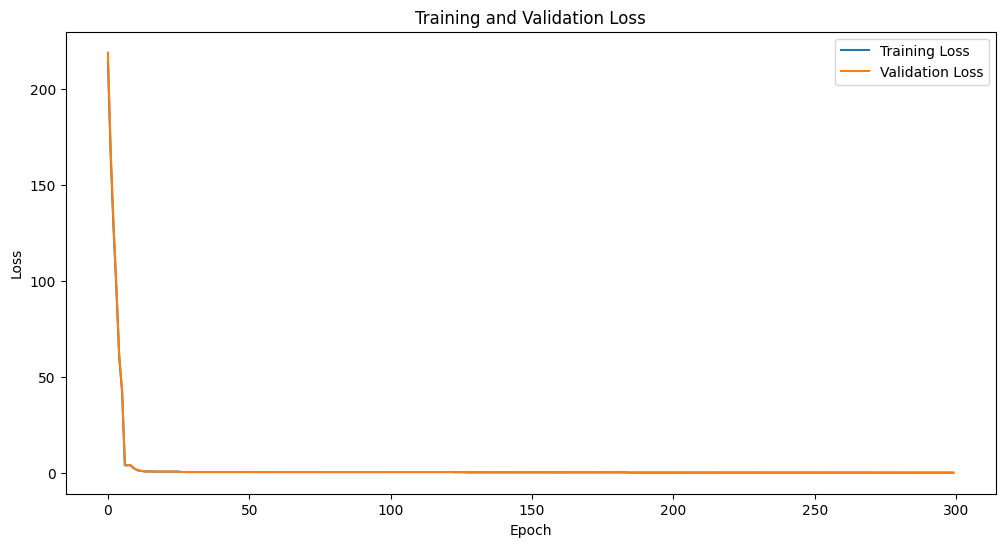

In [5]:
trained_model = compiled_model.fit(train_x_scaled, train_y, 300, validation_data=validation_data)

print("Train accuracy = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

Test accuracy = 0.13700581511115092


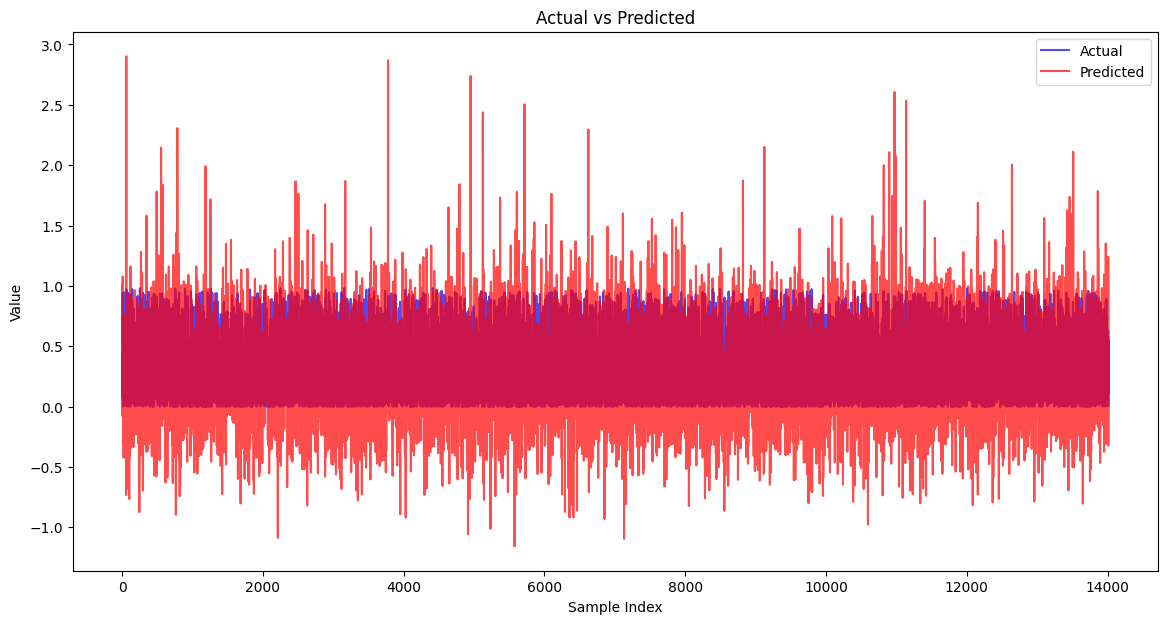

In [6]:
y_predicted = trained_model.predict(test_x_scaled)

print("Test accuracy = " + str(MEAN_SQUARED_ERROR.apply(test_y, y_predicted)))

plot_diff(test_y.flatten(), y_predicted.flatten())

4. Build report

In [7]:
delta = test_y - y_predicted

report = pd.DataFrame(
    {
        "Power RO": test_y.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.188796,0.229465,-0.040669,0.001654
1,0.350296,0.519022,-0.168726,0.028469
2,0.120996,-0.077305,0.198301,0.039323
3,0.075896,0.242819,-0.166923,0.027863
4,0.123996,0.242934,-0.118939,0.014146
5,0.453796,1.004419,-0.550623,0.303186
6,0.087496,0.632676,-0.545180,0.297221
7,0.943296,1.078131,-0.134835,0.018180
8,0.757796,0.378294,0.379502,0.144022
9,0.505096,0.963507,-0.458411,0.210140


Delta total = -1.883386229834793
Delta^2 total = 1.2711900480119425


## Train NN using gradient descent optimizer

1. Define Neural network

In [4]:
model = SeqNet(
    layers=[
        Input(9),
        Dense(128, activation_fun=RELU_ACTIVATION),
        Dense(64, activation_fun=RELU_ACTIVATION),
        Dense(32, activation_fun=RELU_ACTIVATION),
        Dense(1),
    ]
)

opt = GradientDescentOptimizer(learning_rate=0.05, momentum_decay=0.9)

compiled_model = model.compile(
    optimizer=opt,
    loss=MEAN_SQUARED_ERROR,
    progress_tracker=NotebookProgressTracker(),
)

2. Train neural network.

Progress:   0%|          | 0/300 [00:00<?, ?it/s]

Train accuracy = 0.06451924848718124


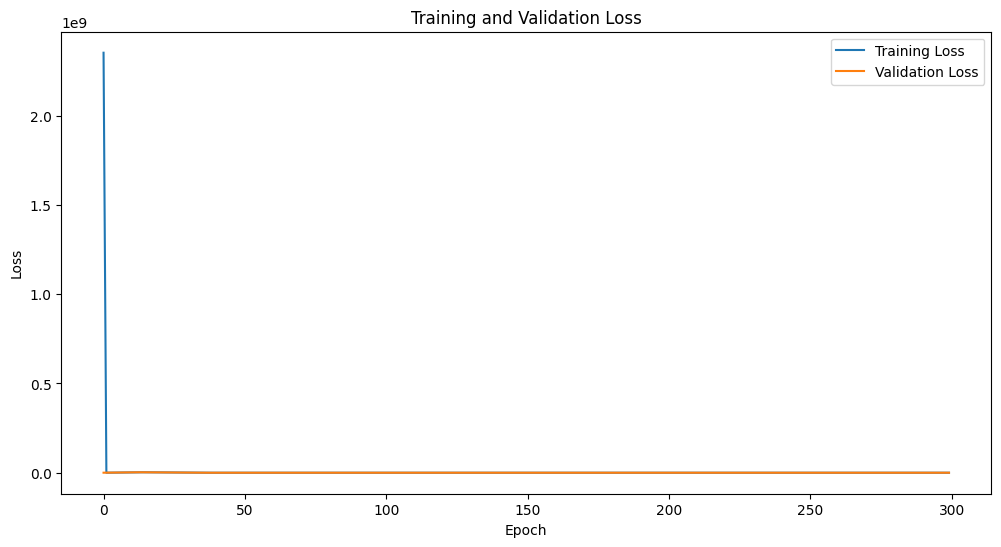

In [5]:
trained_model = compiled_model.fit(
    train_x_scaled, train_y, 300, validation_data=validation_data
)

print("Train accuracy = " + str(trained_model.train_loss()))

plot_loss_and_val_loss(trained_model)

3. Test neural network.

Test accuracy = 0.06372170678034764


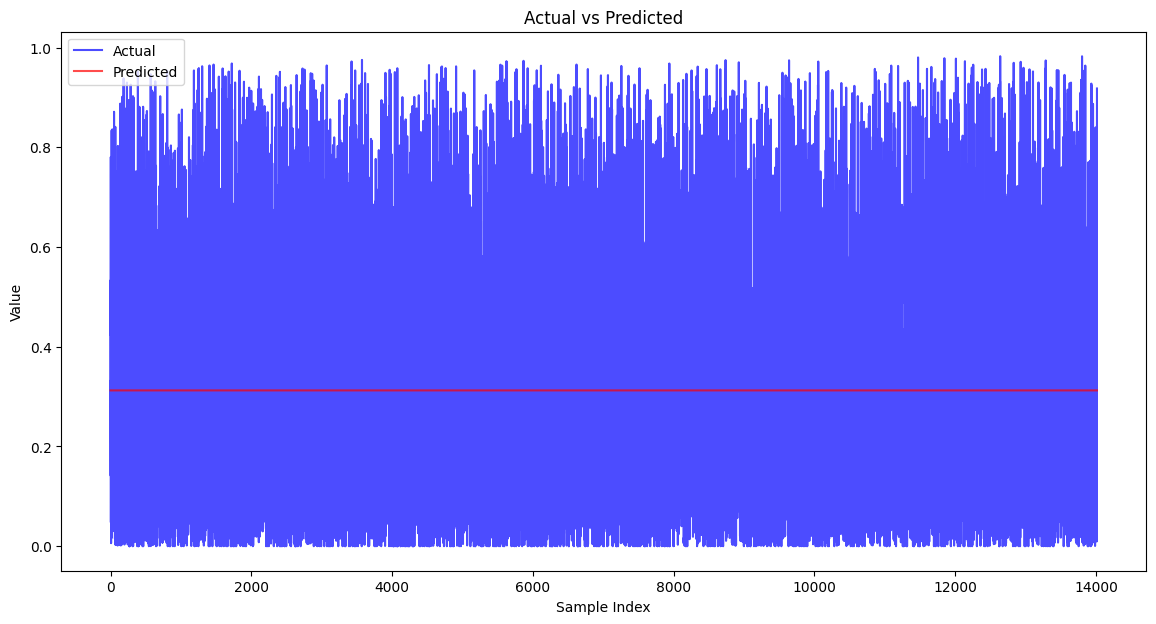

In [6]:
y_predicted = trained_model.predict(test_x_scaled)

print("Test accuracy = " + str(MEAN_SQUARED_ERROR.apply(test_y, y_predicted)))

plot_diff(test_y.flatten(), y_predicted.flatten())

4. Build report

In [7]:
delta = test_y - y_predicted

report = pd.DataFrame(
    {
        "Power RO": test_y.flatten(),
        "Power PO": y_predicted.flatten(),
        "DELTA": delta.flatten(),
        "DELTA^2": np.square(delta.flatten()),
    }
)

report_head = report.head(12)

display(report_head)

print("Delta total = " + str(report_head["DELTA"].sum()))
print("Delta^2 total = " + str(report_head["DELTA^2"].sum()))

,Power RO,Power PO,DELTA,DELTA^2
0,0.424696,0.312492,0.112204,0.012590
1,0.533696,0.312492,0.221204,0.048931
2,0.141296,0.312492,-0.171196,0.029308
3,0.780596,0.312492,0.468104,0.219121
4,0.047796,0.312492,-0.264696,0.070064
5,0.333296,0.312492,0.020804,0.000433
6,0.182296,0.312492,-0.130196,0.016951
7,0.006096,0.312492,-0.306396,0.093879
8,0.177496,0.312492,-0.134996,0.018224
9,0.253396,0.312492,-0.059096,0.003492


Delta total = -0.2553531564518204
Delta^2 total = 0.513677526209159
